In [1]:
from skimage.color import rgb2ycbcr, rgb2lab, rgb2gray, ycbcr2rgb
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

import skimage.transform as tf

from scipy.fftpack import dct
from skimage.metrics import peak_signal_noise_ratio as PSNR

def sub2ind(n_row, row, col):
  return n_row * col + row

def dctmtx(N):
  return dct(np.eye(N), norm='ortho', axis=0)

def func(x, mat):
  return mat @ x @ mat.T

def func1(x, mat):
  return np.multiply(mat, x)

def blockproc(im, mat, block_sz, func):
    h, w = im.shape
    m, n = block_sz
    im_out = np.zeros_like(im)
    for x in range(0, h, m):
        for y in range(0, w, n):
            block = im[x:x+m, y:y+n]
            im_out[x:x+m, y:y+n] = func(block, mat)
    return im_out

In [2]:
def reduce_resolution(image, title, factor):
    """
    reduce each image resolution by a factor of 4 (horizontally and vertically)
    """
    new_shape = image.shape[0] // factor, image.shape[1] // factor
    print(f"Old shape: {image.shape}, New shape: {new_shape}")
    image = tf.resize(image, new_shape, order=1)
    plt.imshow(image, cmap="gray")
    plt.title(title)
    plt.show()
    print(image.shape)
    return image

def digital_zoom(image, factor, order, title):
    """
    Perform digital zoom where order NN = 0, bilinear = 1, bicubic = 3
    """
    new_shape = image.shape[0] * factor, image.shape[1] * factor
    print(f"Old shape: {image.shape}, New shape: {new_shape}")
    image = tf.resize(image, new_shape, order=order)
    plt.imshow(image, cmap="gray")
    plt.title(title)
    plt.show()
    return image

In [3]:
# load peppers image
peppers = imread('../lab_images/peppers.png').astype(np.float64)/255.0
peppers.min(), peppers.max(), peppers.shape

(0.0, 1.0, (384, 512, 3))

Text(0.5, 1.0, 'Image of Peppers')

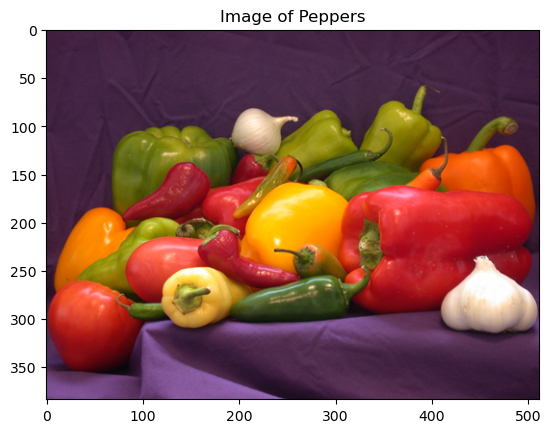

In [4]:
plt.imshow(peppers)
plt.title("Image of Peppers")

In [5]:
# convert from RGB to YCbCr
luma_chroma_peppers = rgb2ycbcr(peppers)
luma_chroma_peppers.shape

(384, 512, 3)

Text(0.5, 1.0, 'Luma Channel For Peppers')

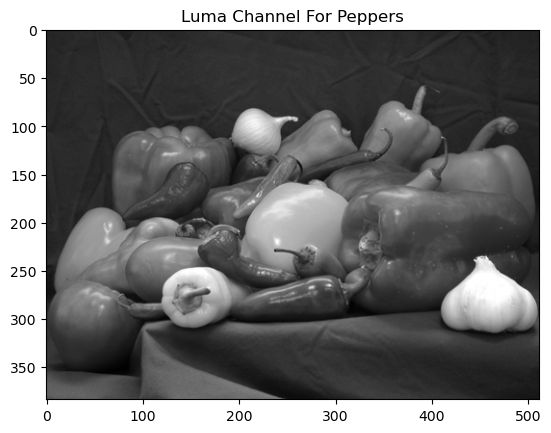

In [6]:
luma = luma_chroma_peppers[..., 0]
cb = luma_chroma_peppers[..., 1]
cr = luma_chroma_peppers[..., 2]

plt.imshow(luma, cmap="gray")
plt.title("Luma Channel For Peppers")

Text(0.5, 1.0, 'Cb Channel For Pepper')

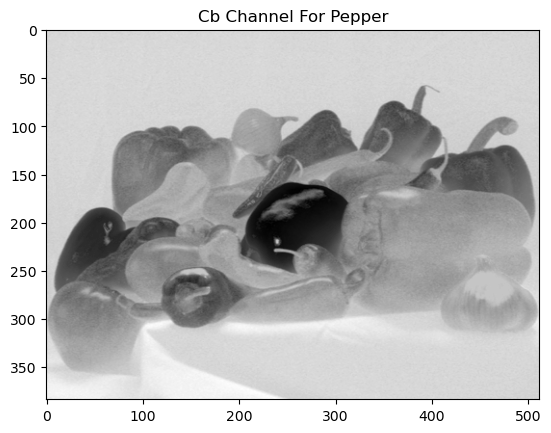

In [7]:
plt.imshow(cb, cmap="gray")
plt.title("Cb Channel For Pepper")

Text(0.5, 1.0, 'Cr Channel For Pepper')

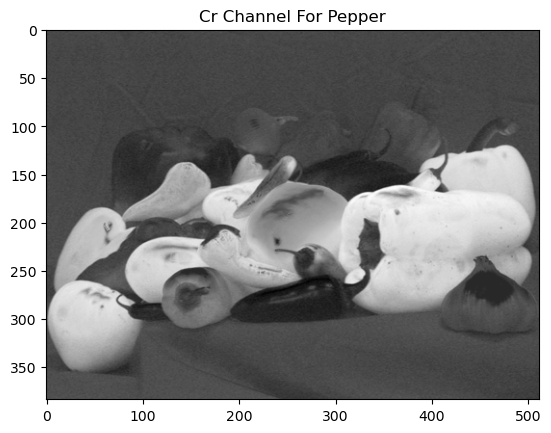

In [8]:
plt.imshow(cr, cmap="gray")
plt.title("Cr Channel For Pepper")

## Questions Part 2
1. Describe the Cb and Cr channel images. Why do they appear this way?

The Cb and Cr channel images are the chroma, or colour parts of the image. They carry lots of colour information... but in general the colour property does not tell us about image structure, just colour. Since different peppers and the background have different colours, the Cr and Cb channels pick up on these colours. As humans, we cannot percieve the changes in colour intensity very clearly. As a result, looking at these channels individually give us a "distorted" view of the images... as we do not pick up on the colour intensity changes as much when we look at the colour images.

2. Compare the level of image detail in the Cb and Cr images with the Y channel image. Which contains more fine details? What does that say about the luma (Y) and chroma (Cb and Cr) channels?

The luma channel comtians much more final details than the chroma channels. This is because the luma has do to with image intensity.. and changes in image intensity correspond to edges... which combine to form structure in the image. Evidently, the luma channel contains much of the edge information that is important to make structure, while the chroma channels contain fine image information which is not as important in the human perception of an image.

Old shape: (384, 512), New shape: (192, 256)


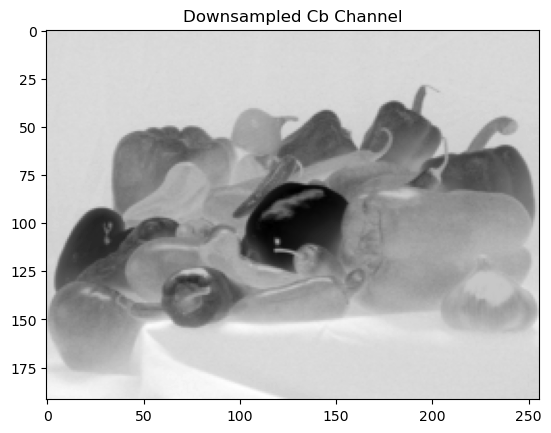

(192, 256)
Old shape: (384, 512), New shape: (192, 256)


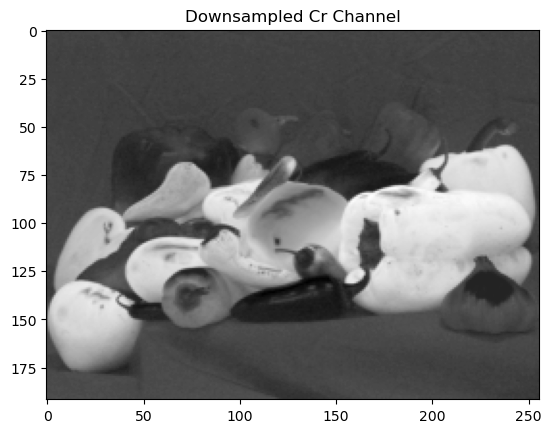

(192, 256)


In [9]:
# reduce chroma channels by a factor of 2 both in horizontal and vertical directions
cb_downsample = reduce_resolution(cb, "Downsampled Cb Channel", 2)
cr_downsample = reduce_resolution(cr, "Downsampled Cr Channel", 2)

Old shape: (192, 256), New shape: (384, 512)


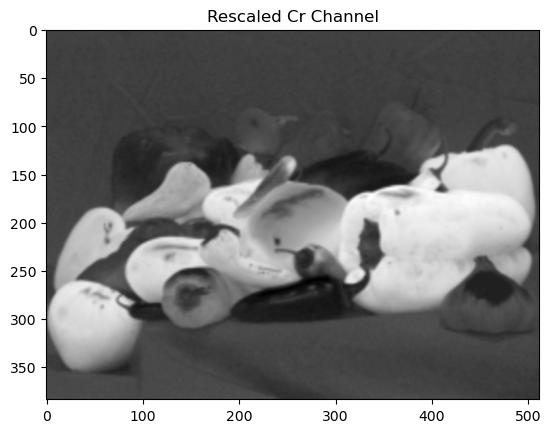

Old shape: (192, 256), New shape: (384, 512)


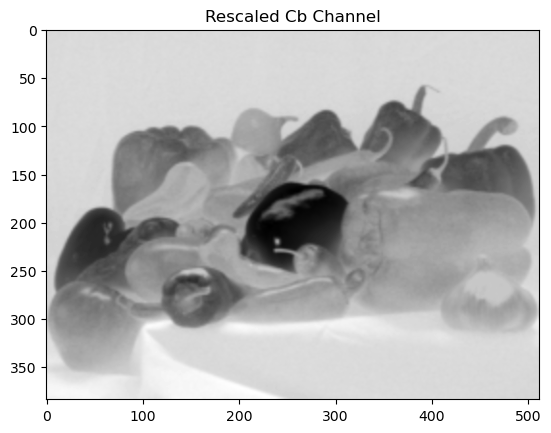

In [10]:
# upsample chroma with bilinear interpolation back to full size
cr_rescale = digital_zoom(cr_downsample, 2, 1, "Rescaled Cr Channel")
cb_rescale = digital_zoom(cb_downsample, 2, 1, "Rescaled Cb Channel")

In [11]:
# recombine the Y with upsampled Cb and Cr to create new image
recombined_channel_peppers = np.stack([luma, cb_rescale, cr_rescale])
recombined_channel_peppers = np.transpose(recombined_channel_peppers, axes=(1, 2, 0))
recombined_channel_peppers_rgb = ycbcr2rgb(recombined_channel_peppers)
recombined_channel_peppers.shape

(384, 512, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17461434003481036..1.116647777085364].


Text(0.5, 1.0, 'Recombined Pepper Image, With Chroma Channels Compressed')

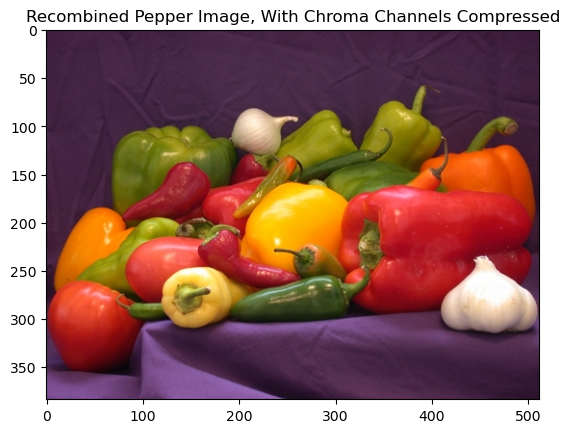

In [12]:
plt.imshow(recombined_channel_peppers_rgb)
plt.title("Recombined Pepper Image, With Chroma Channels Compressed")

## Part 2 Questions
3. Compare the resulting image from chroma sub-sampling with the original image. How large are the visual differences?

The chroma sub-sampled image is pretty close to the original image. The structure from all the peppers is retained, and I visually cannot see any major differences. This makes sense since the luma retained all the structure and the chroma information was not as important.

4. Based on the resulting image, what can you say about chroma sub-sampling and its effect on image quality?

Chroma sub-sampling is an appropriate technique for retaining image quality. It only affects image quality in a minor way which is barely even visible to the human eye - so it is an appropriate form of compression.

Old shape: (384, 512), New shape: (192, 256)


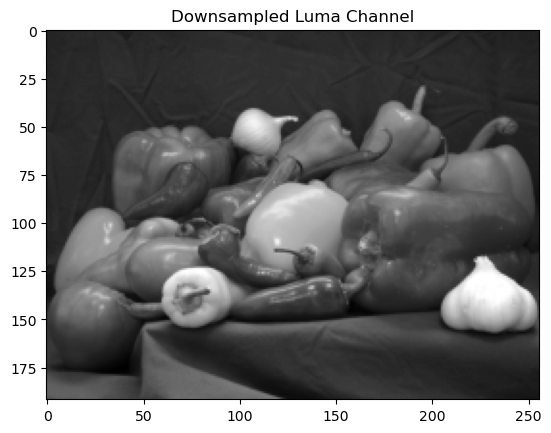

(192, 256)


In [13]:
# subsample luma
luma_downsample = reduce_resolution(luma, "Downsampled Luma Channel", 2)

Old shape: (192, 256), New shape: (384, 512)


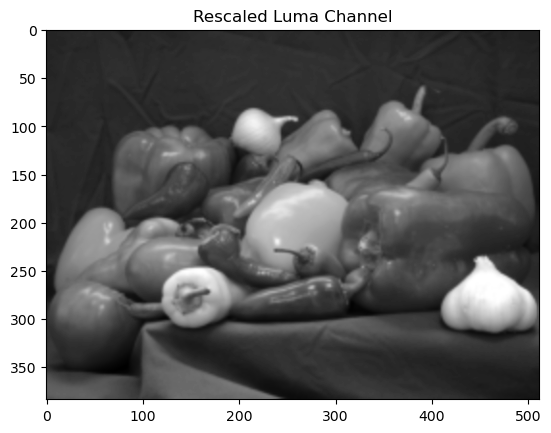

In [14]:
# upscale luma
luma_rescaled = digital_zoom(luma_downsample, 2, 1, "Rescaled Luma Channel")

In [15]:
# recombine rescaled luma with original Cb and Cr channels
recombined_channel_peppers_2 = np.stack([luma_rescaled, cb, cr])
recombined_channel_peppers_2 = np.transpose(recombined_channel_peppers_2, axes=(1, 2, 0))
recombined_channel_peppers_rgb_2 = ycbcr2rgb(recombined_channel_peppers_2)
recombined_channel_peppers_rgb_2.shape

(384, 512, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13072178154792485..1.072384690967729].


Text(0.5, 1.0, 'Recombined Pepper Image, With Luma Compressed')

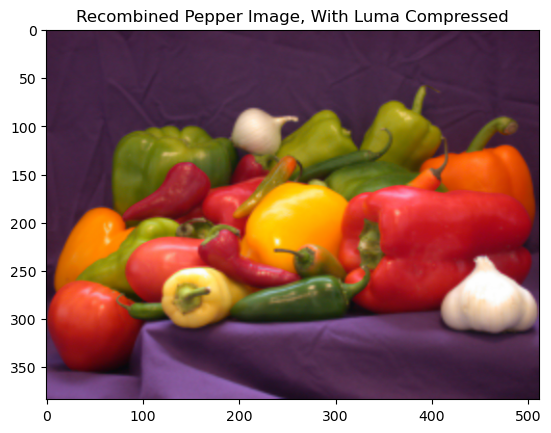

In [16]:
plt.imshow(recombined_channel_peppers_rgb_2)
plt.title("Recombined Pepper Image, With Luma Compressed")

## Part 2 Questions

5. Compare the resulting image from luma sub-sampling with the original image. How large are the visual differences?

The visual difference in this case between the luma sub-sampled image and the original image is not so large, but still noticeable. In general, the peppers in the image have retained their original structure, but the details seem to be blurred, including and textures or patterns on the onion at the top. In general the image appears more blurry, but appears OK. 

6. Based on the resulting image, what can you say about luma sub-sampling and its effect on image quality?

Luma sub-sampling reduces the image quality. This occurs since the luma component has the intensity/edge information, which get decreased when the image is downsampled. As a result, the high frequency content (edges) do not appear restored correctly. 

7. Compare the resulting image from luma sub-sampling with the image produced using chroma subsampling. Which method performs better? Which is better for reducing network bandwidth while preserving visual acuity? Why?

The chroma subsampled method performs better as the high frequency information is retained better and it generally appears like a clear image of the peppers (compared to blurry when luma subsampled). Thus, the chroma subsampled images are better for reducing the network bandwith while preserving the visuals since the human visual system is less sensitive to changes in colour/absolute colour than to image frequencies/structure (coarse details and edges), so having very clear colour information makes little difference, while having clear intensity information is crucial. Furthermore, by subsampling the chroma, we reduce 2 of the channels rather than only reducing 1 with luma subsampling... so we preserve more bandwidth for chroma subsampling AND we achieve better visual results.


In [17]:
peppers_lab_space = rgb2lab(peppers)
m, n, ch = peppers_lab_space.shape

In [18]:
def output_kmean_clusters(K, img):
    if K == 2:
        row = np.array([55, 200]) - 1
        col = np.array([155, 400]) - 1
    elif K == 4:
        row = np.array([55, 130, 200, 280]) - 1
        col = np.array([155, 110, 400, 470]) - 1
    else:
        raise NotImplementedError(f"No Implementation for K = {K}")
    
    img_lab = rgb2lab(img)
    m, n, ch = img_lab.shape

    mu = img_lab[row,col]
    
    img_lab = np.reshape(img_lab, (m*n, ch), order='F')
    kmeans = KMeans(n_clusters=K, init=mu)
    cluster_ids = kmeans.fit_predict(img_lab)
    pixel_labels = np.reshape(cluster_ids, (m, n), order='F')
    plt.imshow(pixel_labels, cmap='jet')
    plt.title(f'Image labeled by Cluster Index for K = {K}')
    return pixel_labels

In [19]:
#K = 2
#row = np.array([55, 200]) - 1
#col = np.array([155, 400]) - 1
K = 4
row = np.array([55, 130, 200, 280]) - 1
col = np.array([155, 110, 400, 470]) - 1
mu = peppers_lab_space[row,col]
mu.shape

(4, 3)

In [20]:
peppers_lab_space = np.reshape(peppers_lab_space, (m*n, ch), order='F')
peppers_lab_space.shape

(196608, 3)

In [21]:
kmeans = KMeans(n_clusters=K, init=mu)
cluster_ids = kmeans.fit_predict(peppers_lab_space)
cluster_ids.shape

(196608,)

In [22]:
pixel_labels = np.reshape(cluster_ids, (m, n), order='F')
pixel_labels.shape

(384, 512)

Text(0.5, 1.0, 'Image labeled by cluster index')

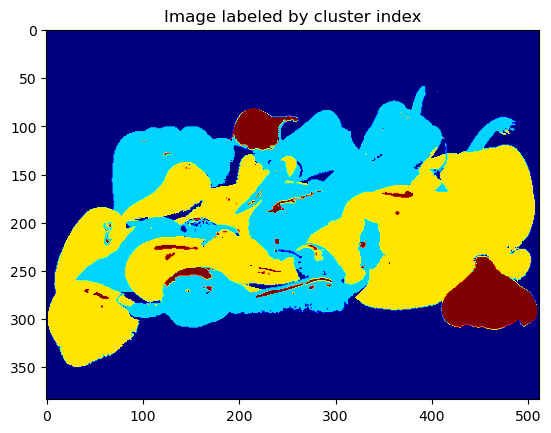

In [23]:
# Label each pixel according to k-means
plt.imshow(pixel_labels, cmap='jet')
plt.title('Image labeled by cluster index')

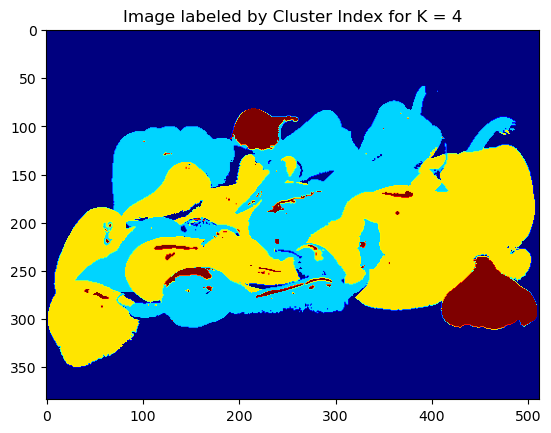

In [24]:
pix_labels = output_kmean_clusters(4, peppers)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

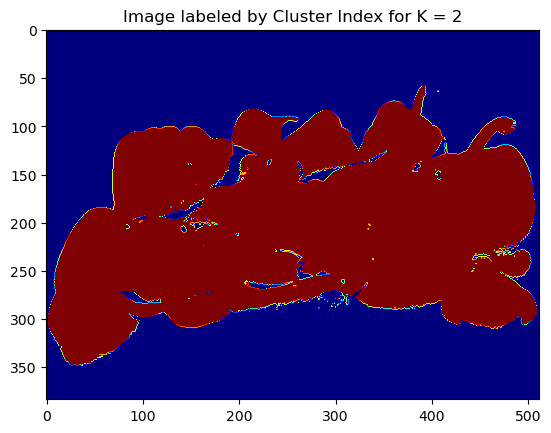

In [25]:
output_kmean_clusters(2, peppers)

## Part 3 Qs
8. For the various values of k, how did the clustering change? Explain.

For K=2, the clustering generally identifies between the peppers and the background. This makes sense since the background is one distinct colour compared to the peppers, so the clustering in L*/a*/b* image space is able to distinguish the distinct purple background from the colourful peppers. For K=4, we can see that the peppers were further clustered into more groups (red peppers vs green peppers vs white onions/peppers), while still segmenting the background. 

9. What is the effect of the initial points on the final clusters? Does this impose any limitations? Why?

The initial point provides a starting location for the kmeans algorithm, where the clusters get updated in a distance based manner (euclidean distance). However, the 'migrating means' can get stuck in local minimas, purely depending on the distribution and where the initial point was. This can further be a problem if 2 clusters start very close to eachothe and have problems breaking apart after. It means that our clustering may not be fully optimal after the first full cycle of the algorithm due to faulty starting points... so stochastically choosing starting points and finding best distance based metrics mitigates this concern.


In [26]:
pix_labels.shape, pix_labels.min(), pix_labels.max()

((384, 512), 0, 3)

In [ ]:
cluster_0_mask = pix_labels == 0
cluster_0_mask.shape, peppers.shape, cluster_0_mask.min(), cluster_0_mask.max()

((384, 512), (384, 512, 3), False, True)

In [28]:
cluster_0_img = peppers.copy()
cluster_0_img[~cluster_0_mask] = 0
cluster_0_img.shape

(384, 512, 3)

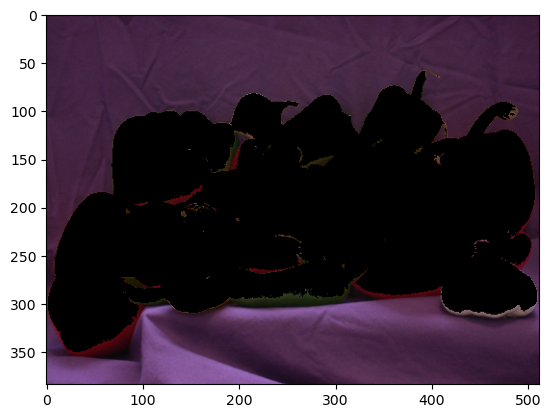

In [29]:
plt.imshow(cluster_0_img)

In [30]:
def plot_img_cluster(label, img, pixel_labels):
    cluster_mask = pixel_labels == label
    cluster_img = img.copy()
    cluster_img[~cluster_mask] = 0
    plt.imshow(cluster_img)
    plt.title(f"Image Representation for Cluster {label}")
    plt.show()


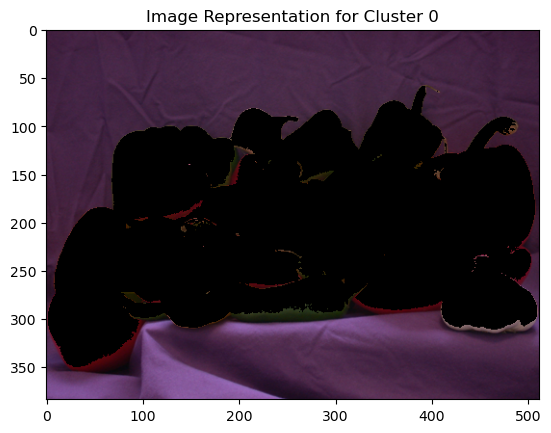

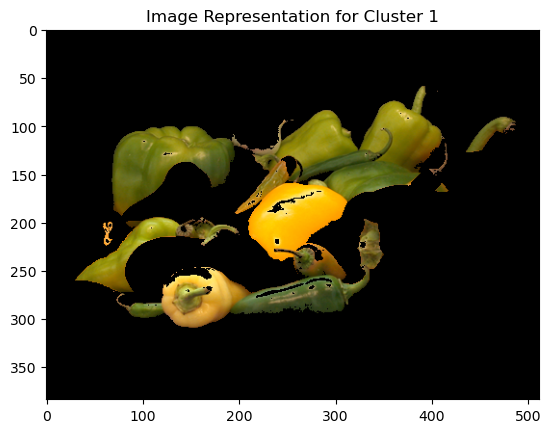

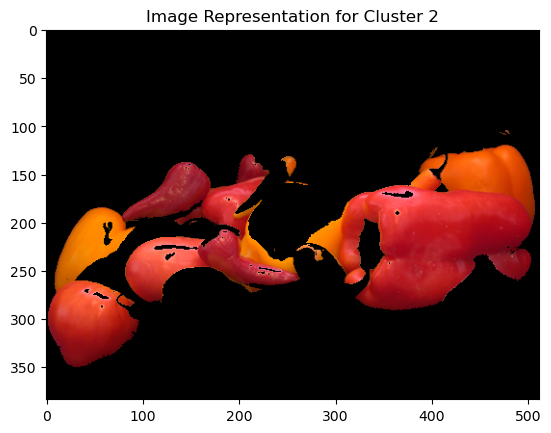

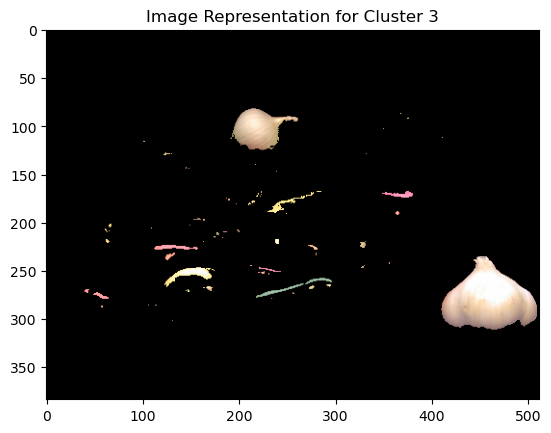

In [31]:
for label in [0, 1, 2, 3]:
    plot_img_cluster(label, peppers, pix_labels)

## Part 3 Qs

10. Include an image of each cluster and comment on the segmentation performance

The segmentation generally performs well. In the first cluster, we see the background. The second has green and yellow peppers. Third has red and orange peppers, and last one has the white onions/peppers, along with some noisy patches of other parts of the image. We see these high level ideas being segmented.. but still have issues with noise and segmentation boundaries. The background still includes small parts of many peppers, and peppers have small chunks that have been segmented out. Overall, it points to OK segmentation, but still lots of room for improvement.

In [41]:
# image transform
dct_T_matrix = dctmtx(8)
dct_T_matrix.shape, dct_T_matrix.min(), dct_T_matrix.max()

((8, 8), -0.4903926402016152, 0.4903926402016152)

(512, 512)


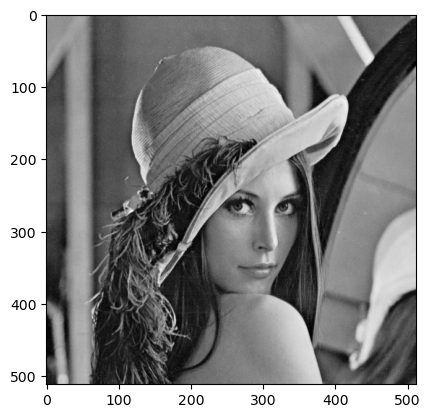

In [ ]:
lena = rgb2gray(imread('../lab_images/lena.tiff'))
print(lena.shape)
plt.imshow(lena, cmap="gray")

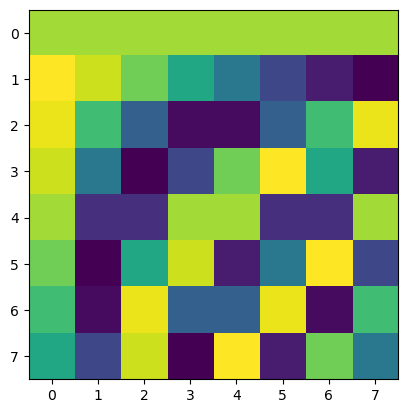

In [35]:
plt.imshow(dct_T_matrix)

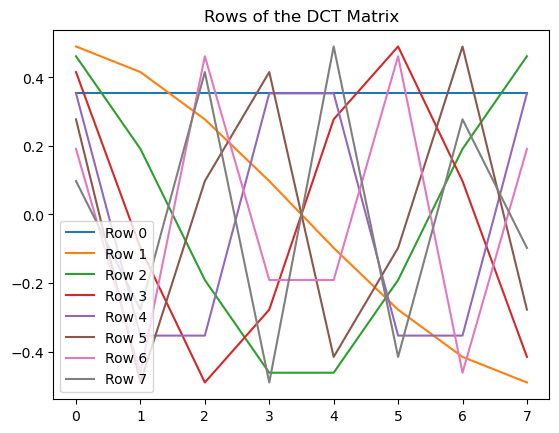

In [50]:
# plot each row as a function
for i, row in enumerate(dct_T_matrix):
    plt.plot(np.arange(0, 8), row, label=f"Row {i}")
    plt.title("Rows of the DCT Matrix")
    plt.legend()

## Part 4 Qs

11. What does each row of the DCT transform matrix represent? Look at the pattern for each row. If you still don’t see it, try plotting each of the rows as a 1-D function.

Each row of the DCT transform matrix represent a sinusoid of varying frequencies (and it appears that they have similar or the same amplitudes, in this graph). For example, we can see that the 0th row is just the DC gain component, 1st row is a sinusoid that only has half of it's period, 2nd row is a sinusoid with it's full period, 3rd row is a sinusoid with 1.5 periods. Evidently, they are sinusoids with varying frequencies.

In [51]:
lena.min(), lena.max()

(0.07254666666666668, 0.9654356862745097)

In [59]:
lena = (rgb2gray(imread('../lab_images/lena.tiff')) * 255).astype(int)
lena.min(), lena.max(), lena.shape

(18, 246, (512, 512))

In [58]:
lena_dct = np.floor(blockproc(lena-128, dct_T_matrix, [8, 8], func))    
lena_dct.shape

(512, 512)

In [65]:
first_dct_patch = np.abs(lena_dct[80:80+8, 296: 296+8])
second_dct_patch = np.abs(lena_dct[0: 8, 0: 8])
first_dct_patch.shape, second_dct_patch.shape, first_dct_patch.min(), first_dct_patch.max()

((8, 8), (8, 8), 0.0, 390.0)

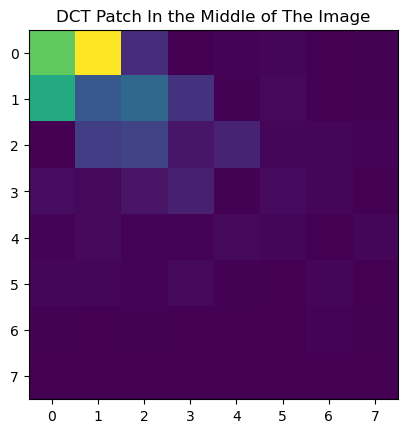

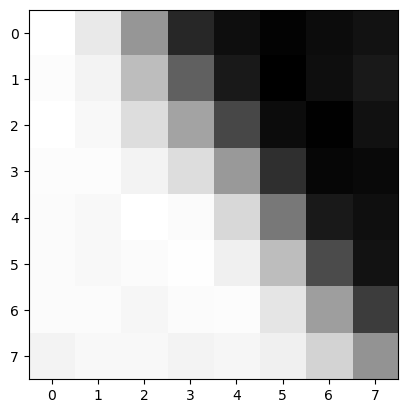

In [73]:
plt.imshow(first_dct_patch)
plt.title("DCT Patch In the Middle of The Image")
plt.show()
plt.imshow(lena[80:80+8, 296: 296+8], cmap="gray")

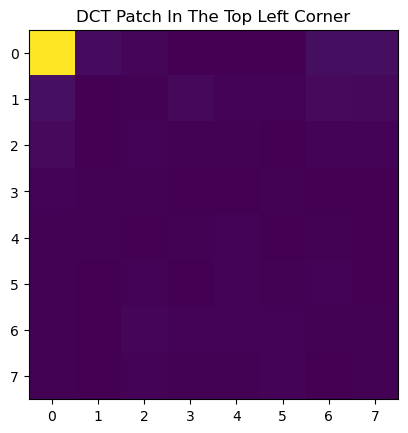

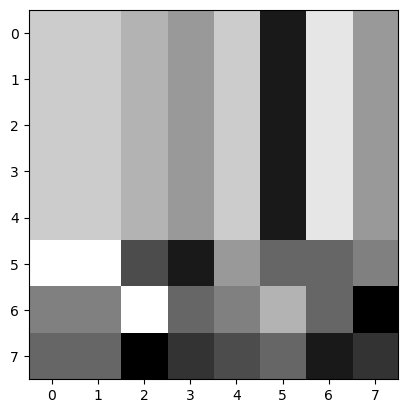

In [77]:
plt.imshow(second_dct_patch)
plt.title("DCT Patch In The Top Left Corner")
plt.show()
plt.imshow(lena[0: 8, 0: 8], cmap="gray")

## Part 4 Q's

12. Describe the energy distribution of the DCT of the sub-images. What does each pixel represent? Explain why DCT would be useful for image compression in the context of the DCT energy distribution.

The energy distribution of the DCT of the sub-images represents the magnitude of the frequency components, where the (0, 0) pixel corresponds to the DC gain in the patch and (8, 8) has the highest frequency, increasing along each of the axes. For the first DCT sub-image, we can see the energy being distributed mostly along the low-mid frequency ranges, while in the second subimage the DCT transform is very clearly in the low frequency range. DCT is useful for image compression since it enables matching with different frequency filters, where the energy distribution is generally going to be in the low to mid ranges (as seen previously by Fourier Transforms). As a result, many of the high frequency components can be discarded,which leads to compression.

13. Compare the DCT of the two sub-images. How are they different? Why? Explain in the context of the image characteristics at those locations and the DCT energy distribution.

We note that the first DCT sub-image has frequency components in the low to mid frequnecy ranges, while the second (top left corner) is dominated by the low frequency range (particularly the DC gain). Relating back to the image characteristics, we can see in the that the first subimage has a diagonal gradient going from bottom left to top right, as well as some solid areas in the bottom left/top right corners. As a result of this pattern, we can see varying frequency components in the image, which is shown by the DCT of the subimage (ie. frequencies in the low and mid range exist). In the second subimage, it is taking the DCT of the top left of the image which contains the image border information. It seems to not have much information, just a few noise-like high frequency components and otherwise similar looking background information. The DCT shows this by having a heavy focus on the DC gain component, and small amounts of mid to high frequencies as a result of the noise.

Thus: subimage one has detail, and shows low to mid frequency ranges in DCT and subimage 2 is background/border, which has almost no detail and shows mainly DC gain/low frequency in the DCT.

Text(0.5, 1.0, 'Mask Keeping Only Low Freq Components')

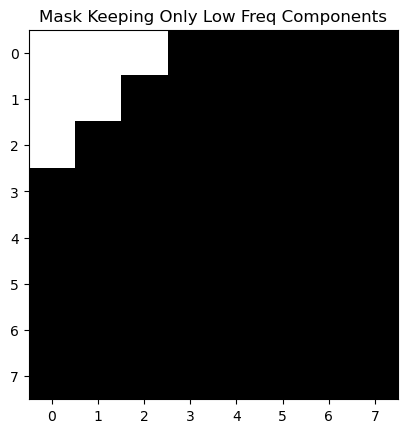

In [81]:
mask = np.zeros((8 , 8 ))
mask [ 0 , 0 ] = 1
mask [ 0 , 1 ] = 1
mask [ 0 , 2 ] = 1
mask [ 1 , 0 ] = 1
mask [ 1 , 1 ] = 1
mask [ 2 , 0 ] = 1

plt.imshow(mask, cmap="gray")
plt.title("Mask Keeping Only Low Freq Components")

In [ ]:
lena_dct_thresh = blockproc(lena_dct , mask , [8 , 8] , func1)
lena_thresh = np.floor(blockproc(lena_dct_thresh, dct_T_matrix.T, [8, 8], func)) + 128
lena_thresh.shape

(512, 512)

In [94]:
lena_thresh.min(), lena_thresh.max()

(-26.0, 276.0)

Text(0.5, 1.0, 'Lena Reconstructed With Only Low Freq Components of DCT')

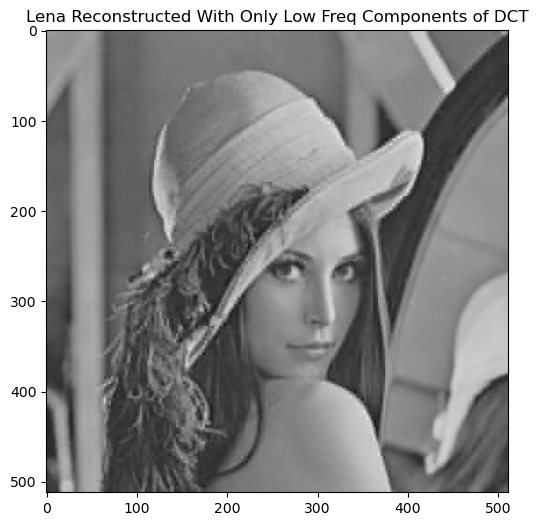

In [97]:
plt.figure(figsize=(6, 6))
plt.imshow(lena_thresh, cmap="gray")
plt.title("Lena Reconstructed With Only Low Freq Components of DCT")

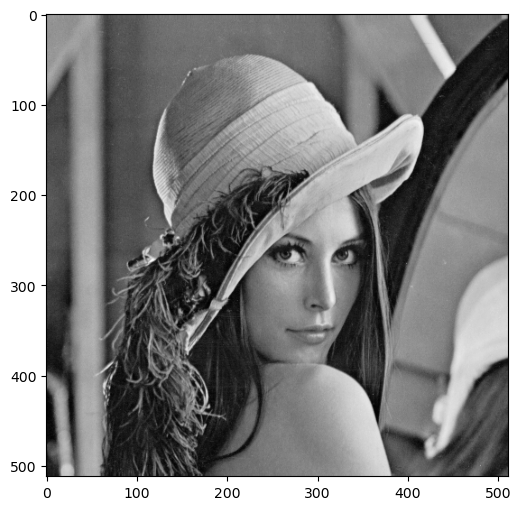

In [98]:
plt.figure(figsize=(6, 6))
plt.imshow(lena, cmap="gray")

In [88]:
lena_thresh.max()

276.0

In [92]:
print(f"The PSNR between original Lena and reconstructed Lena is {round(PSNR(lena, lena_thresh, data_range=255), 3)}")

The PSNR between original Lena and reconstructed Lena is 29.47


## Part 4 Q's

14. Describe how the reconstructed image looks compared to the original image. Why does it look this way?

The reconstructed image looks blurred compared to the original image. It looks this way since we applied a mask to the DCT that has kept mainly the low frequency components (and thrown away many of the high frequency and some of the mid frequency components). This would be similar to applying a low pass filter in the frequency domain, where we have cancelled many of the high frequency components, and thus end up with a smoothed/blurred image - as observed. 

15. What artifact is most prominent in the image? Why does this artifact appear?

By enlarging the image, it is evident that blocking artifacts are most prominent in the image. It appears since the DCT processes each 8x8 sub-image independently, and thus computes a different DC value (0 frequency) for each sub-image. When reconstructed, the varying DC gain value will create a blocking artifact, as adjacent subimages have different DC components, forming the blocking artifact.

16. What conclusions can you draw about the DCT in terms of image compression? Does it work well? If yes, why does it work well?

Looking back at the PSNR between the lena and the reconstructed image, we can see it is relatively high - almost at a value of 30. We note that we currently hard coded a mask to take only the low frequency components from the DCT, however, an adaptive mask could be possible with the DCT since it tells us about which frequency components matter (as we saw with the sub-image comparison in the part before). Thus, DCT is a great tool for image compression since it tells us about the importance of different frequency components in a sub-image and allows us to keep the ones which matter in a patch while throwing away the rest. It is also computationally efficient since we only need one transform to compute the transform and it's inverse, making it a computationally efficient approach.

In [ ]:
# part 5
Z = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

Z.shape

(8, 8)

In [106]:
np.tile(Z, (64, 64))[:10, :10]

array([[ 16,  11,  10,  16,  24,  40,  51,  61,  16,  11],
       [ 12,  12,  14,  19,  26,  58,  60,  55,  12,  12],
       [ 14,  13,  16,  24,  40,  57,  69,  56,  14,  13],
       [ 14,  17,  22,  29,  51,  87,  80,  62,  14,  17],
       [ 18,  22,  37,  56,  68, 109, 103,  77,  18,  22],
       [ 24,  35,  55,  64,  81, 104, 113,  92,  24,  35],
       [ 49,  64,  78,  87, 103, 121, 120, 101,  49,  64],
       [ 72,  92,  95,  98, 112, 100, 103,  99,  72,  92],
       [ 16,  11,  10,  16,  24,  40,  51,  61,  16,  11],
       [ 12,  12,  14,  19,  26,  58,  60,  55,  12,  12]])

In [156]:
def plot_dct_reconstructed_image(img, compression_coeff, quantization_matrix = Z, subimg_dim = 8):
    # note: assumes image scaled [0, 255]
    dct_matrix = dctmtx(subimg_dim)
    img_dct = np.floor(blockproc(img-128, dct_matrix, [subimg_dim, subimg_dim], func))
    Z_scaled = compression_coeff * quantization_matrix

    tile_amount = int(img.shape[0] / subimg_dim)
    Z_scaled = np.tile(Z_scaled, (tile_amount, tile_amount))
    img_dct_quantized = np.round(img_dct / Z_scaled).astype(int)
    print(f"The number of non-zero coefficients after DCT quantization is: {np.count_nonzero(img_dct_quantized)} / {(img.shape[0] * img.shape[0])} total coefficients")

    # reconstruct the image
    img_dct_recovered = img_dct_quantized * Z_scaled
    img_recovered = blockproc(img_dct_recovered, dct_T_matrix.T, [subimg_dim, subimg_dim], func) + 128

    plt.imshow(img_recovered, cmap="gray")
    plt.title(f"Compressed Image Reconstruction With Compression Factor {compression_coeff}")

    print(f"The PSNR for the reconstruction is {round(PSNR(img, img_recovered, data_range=255), 3)}")

The number of non-zero coefficients after DCT quantization is: 27666 / 262144 total coefficients
The PSNR for the reconstruction is 35.328


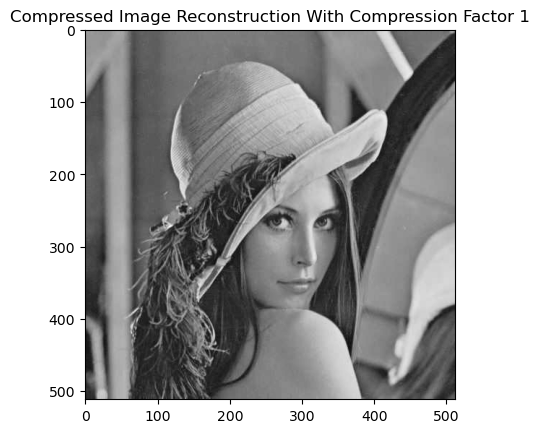

In [157]:
plot_dct_reconstructed_image(lena, 1)

The number of non-zero coefficients after DCT quantization is: 14180 / 262144 total coefficients
The PSNR for the reconstruction is 32.016


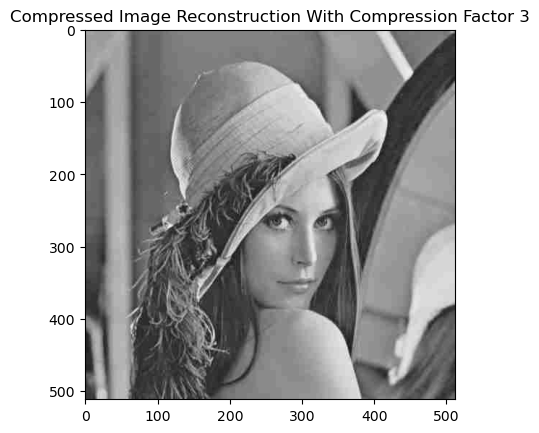

In [158]:
plot_dct_reconstructed_image(lena, 3)

The number of non-zero coefficients after DCT quantization is: 10237 / 262144 total coefficients
The PSNR for the reconstruction is 30.145


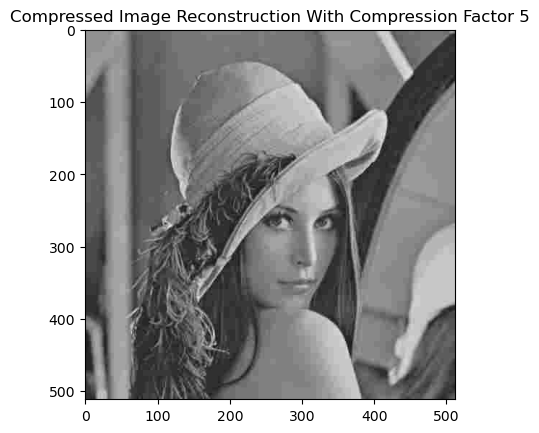

In [159]:
plot_dct_reconstructed_image(lena, 5)

The number of non-zero coefficients after DCT quantization is: 6449 / 262144 total coefficients
The PSNR for the reconstruction is 27.18


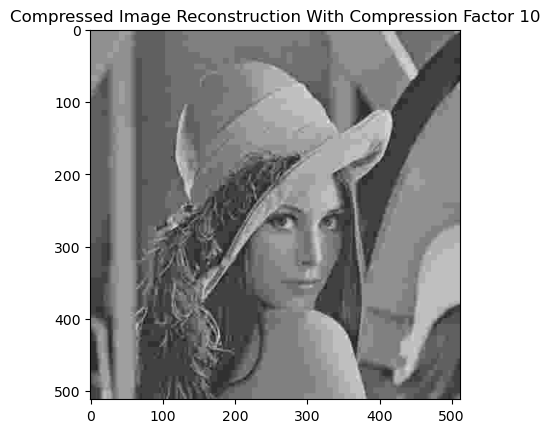

In [160]:
plot_dct_reconstructed_image(lena, 10)

## Part 5 Q's

17. What happens to the DCT coefficients when quantization is performed? What effect does it have on image quality?

When quantization is performed, the DCT coefficient which are under 0.5 end up going to 0 (due to integer rounding). Generally speaking, it will be high frequency components which have lower values in the subimages, so many of these will get dropped to 0 after quantization. As a result, many of the blocks will keep only their lower to mid frequnecy components, and thus high frequency details in the sub-images will be removed. Large amounts of quantization can greatly reduce image quality by cancelling many of the mid/high frequencies (blurring). Furthermore, the independent high-frequency removal and DC gain calculation of subimages will cause a blocking artifact, further reducing the quality of images. However, small quantization will reduce only high frequency components which do not matter for the image quality, as seen when the quantization coefficient is set to 1. 

18. Compare the reconstructed image produced using 3Z with the original image. Why does the reconstructed image look this way?

The reconstructed imae produced using 3Z compared to the original image looks more blurred. This happens because the DCT quantization by a factor of 3 has removed about half of the coefficents (about 28,000 DCT coefficient with factor of 1 vs 14,000 DCT coefficients with factor 3). As a result, many of the mid frequency components have been removed from each of the DCT subimages, which leads to removing detail for the resulting image. However, there are still enough DCT coefficients to make the reconstruction good (PSNR = 35.3 vs PSNR = 32.0, both relatively close and good).

19. Compare the reconstructed images produced by the different levels of quantization, as well as the PSNR for each reconstructed image. What happens as the level of quantization increases?

The reconstructed images get worse as the quantization increases, as more and more DCT coefficients are thrown away by higher quantization. This is evident in the PSNR as well, as it drops from 35, to 32, to 30, to 27 (with increasing levels of quantization) matching with the observations. 


20. Which artefact becomes more prominent as the level of quantization increases? Why?

The blocking artifact becomes more prominent as the level of quantization increases. As previously explained, this happens because very strong quanitization removes all mid and high frequency components, only leaving the low frequency component behind. Since each 8x8 subimage is processed independently, the DC gain for each subimage will be different and will be the main component in the reconstruction, resulting in a blocking artifact as adjacent pixels have different DC components. 


21. What conclusions can you draw about the quantization process? Explain in the context of the trade-off between compression performance and image quality.

The quantization process is what enables compression after applying the DCT, and dictates the final resolution of the produced image. Higher amounts of compression will occur with more quantization, but will also greatly reduce the image quality - making it more blurred and adding blocking artifacts. Conversely, lower levels of quantization will increase the quality and remove artifacts... but reduce compression which is what we want to have. As a result, we want to compress the images by an acceptable amount, while not throwing away too much information. 